In [1]:
import pandas as pd  # Tabular data
from glob import glob  # File pattern matching
import os  # Operating System
import geopandas as gpd  # Geospatial data
import re  # Regular expressions
import math
from tqdm.auto import tqdm  # Progress bars
from tqdm.contrib.concurrent import thread_map, process_map  # Parallel operations
import rapidfuzz # Fuzzy string matching

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 130)
df = pd.read_csv("meta.csv")
# Filter to just shapefiles that have the CRS column defined
df = df[df.CPS & (df.n_lines > 0)]
df["Pixel_ER"] = (
    df.res.str.replace("(", "", regex=False).str.split(",").str[0].astype(float)
)
df = df[["filename", "matched_image", "Pixel_ER"]]
# Testing with BigBay
# df = df[df.filename.str.contains("BigBay")]
df

,filename,matched_image,Pixel_ER
1,Retrolens/Tasman/Motueka/Shorelines/Motueka_22SEP1969.shp,Retrolens/Tasman/Motueka/Stack/Motueka_22SEP1969_mosaic.jp2,0.700000
2,Retrolens/Tasman/Motueka/Shorelines/Motueka_27MAR1947.shp,Retrolens/Tasman/Motueka/Stack/Motueka_27MAR1947_mosaic.jp2,0.550000
3,Retrolens/Tasman/Motueka/Shorelines/Motueka_19MAY1958.shp,Retrolens/Tasman/Motueka/Stack/Motueka_19MAY1958_mosaic.jp2,1.250000
4,Retrolens/Tasman/ TorrentBay/Shorelines/TorrentBay_09APR1965.shp,Retrolens/Tasman/ TorrentBay/Stack/TorrentBay_09APR1965_mosaic.jp2,0.763318
5,Retrolens/Tasman/ TorrentBay/Shorelines/TorrentBay_04MAY1944.shp,Retrolens/Tasman/ TorrentBay/Stack/TorrentBay_04MAY1944_mosaic.jp2,0.743579
...,...,...,...
1329,MaxarImagery/HighFreq/WestCoast/CartersBeach/Shorelines/CartersBeach_02MAR2019.shp,MaxarImagery/HighFreq/WestCoast/CartersBeach/Imagery/Stack/CartersBeach_02MAR2019.tif,0.500000
1330,MaxarImagery/HighFreq/WestCoast/Ohinemaka/Shorelines/Ohinemaka_25MAR2010.shp,MaxarImagery/HighFreq/WestCoast/Ohinemaka/Imagery/Stack/Ohinemaka_25MAR2010.tif,0.500000
1333,MaxarImagery/HighFreq/WestCoast/Ohinemaka/Shorelines/Ohinemaka_08MAR2022.shp,MaxarImagery/HighFreq/WestCoast/Ohinemaka/Imagery/Stack/Ohinemaka_08MAR2022.tif,0.500000
1338,MaxarImagery/HighFreq/Wellington/KapitiMid/Shorelines/KapitiMid_19JAN2006.shp,MaxarImagery/HighFreq/Wellington/KapitiMid/Imagery/Stack/KapitiMid_19JAN2006.tif,0.600000


Total UNCY:  
Total shoreline uncertainty (Et) is calculated as the root sum of squares of the pixel error (Ep), georeferencing error (Eg) and digitising error (Ed)  

$E_t = \sqrt{E_p^2 + E_g^2 + E_d^2}$

In [3]:
def get_scale(filename, DSASDate, year):
    # Find CSV for AOI
    bits = filename.split("/")
    terminator = min(
        bits.index("Stack") if "Stack" in bits else 1024,
        bits.index("Shorelines") if "Shorelines" in bits else 1024,
    )
    bits = bits[:terminator]
    csv_path_pattern = f"ressci201900060-RNC2-Coastal/{'/'.join(bits)}/*.csv"
    csv_candidates = glob(csv_path_pattern)
    if len(csv_candidates) == 0:
        print(f"No CSV found for {csv_path_pattern}")
    elif len(csv_candidates) > 1:
        print(f"Ambiguous CSVs: {csv_candidates}")
        csv_candidates = [csv_candidates[0]]
    assert len(csv_candidates) == 1
    csv_filename = csv_candidates[0]
    try:
        csv = pd.read_csv(csv_filename, encoding="cp1252")
    except UnicodeDecodeError:
        # Excel file saved with .csv extension
        print(f"{csv_filename} is actually an Excel file")
        csv = pd.read_excel(csv_filename)
        csv.Date = csv.Date.astype(str)
    if "RMSE" not in csv.columns:
        print(f"{csv_filename} has no RMSE column")
    

    # Fuzzy string match dates. Lots of typos.
    matched_date, score, index = rapidfuzz.process.extractOne(query=DSASDate, choices=csv.Date.unique())
    if score < 50:
        # Terrible match score, just use year
        matched_date, score, index = rapidfuzz.process.extractOne(query=year, choices=csv.Date.unique())
        print(f"Matching {year} to {matched_date} with score {score} for {csv_filename}")
    elif DSASDate != matched_date:
        print(f"Matching {DSASDate} to {matched_date} with score {score} for {csv_filename}")
    filtered_csv = csv[(csv.Date == matched_date) & ~csv.RMSE.isna()]
    scales = filtered_csv.Scale.unique()
    if len(scales) == 0:
        print(f"No scales found for {csv_filename} for date {DSASDate}, removing RMSE filter")
        filtered_csv = csv[(csv.Date.str.contains(matched_date))]
        scales = filtered_csv.Scale.unique()
        print(f"Scales now: {scales}")
        if len(scales) == 0:
            print(f"Still no scales found for {csv_filename} for date {matched_date}, reducing date filter just to year from filename {year}")
            filtered_csv = csv[(csv.Date.str.contains(year))]
            scales = filtered_csv.Scale.unique()
            print(f"Scales now: {scales}")
    if len(scales) > 1:
        scales = filtered_csv.Scale.value_counts()
        print(f"Ambiguous scales found for {csv_candidates[0]} for date {DSASDate}: {scales}. Taking {scales.index[0]}")
        scales = [scales.index[0]]
    if len(scales) == 0:
        print(f"Can't find a scale for {filename}")
    assert len(scales) == 1
    return scales[0]


def get_Georef_ER(scale):
    if scale < 20000:
        return 2.09
    elif scale < 30000:
        return 2.43
    else:
        return 2.9


CPS_error_lookup = {1: 0.43, 2: 0.73, 3: 0.97, 4: 2.07, 5: 8.59}

for i, row in tqdm(df.iterrows(), total=len(df)):
    filename = row.filename
    year = re.search(r'(\d{4})', filename).group(1)
    shapefile = gpd.read_file(filename)
    if len(shapefile) == 0:
        print(f"{filename} is empty")
        continue
    if "Source" not in shapefile.columns:
        print(f"{filename} has no Source")
        if filename.startswith("Retrolens"):
            source = "RL"
        elif filename.startswith("MaxarImagery/HighFreq"):
            source = "MAX"
        else:
            source = "Unknown"
    else:
        sources = shapefile.Source.unique()
        if len(sources) == 0 or not sources[0]:
            print(f"{filename} has no sources")
            if filename.startswith("MaxarImagery/HighFreq"):
                sources = ["MAX"]
            else:
                sources = ["Unknown"]
        if len(sources) > 1:
            print(f"{filename} has ambiguous sources: {sources}")
        source = sources[0]

    if source != "MAX" and filename.startswith("MaxarImagery"):
        print(f"{filename} doesn't have MAX source, overriding")
        source = "MAX"

    if source == "MAX":
        photoscale = "VHR"
        Georef_ER = 1.17
    elif source == "LDS":
        photoscale = "VHR"
        Georef_ER = 0
    else:
        dates = shapefile.DSASDate.unique()
        if len(dates) > 1:
            print(f"{filename} has ambiguous DSASDates: {dates}")
        if len(dates) == 0 or not dates[0]:
            print(f"{filename} has no DSASDate")
            DSASDate = year
        else:
            DSASDate = shapefile.DSASDate.unique()[0].lstrip("0")
        photoscale = get_scale(filename, DSASDate, year)
        Georef_ER = get_Georef_ER(photoscale)

    # Store inputs in shapefile
    shapefile["Photoscale"] = photoscale
    shapefile["Georef_ER"] = Georef_ER
    shapefile["Pixel_Er"] = row.Pixel_ER

    # Calculate Total_UNCY
    Ep = row.Pixel_ER
    Eg = Georef_ER
    for i, row in shapefile.iterrows():
        if row.CPS not in CPS_error_lookup:
            continue
        Ed = CPS_error_lookup[row.CPS]
        Et = math.sqrt(Ep**2 + Eg**2 + Ed**2)
        shapefile.loc[i, "Total_UNCY"] = Et
    # display(shapefile)
    # To write results back to file:
    shapefile.to_file(filename)

  0%|          | 0/441 [00:00<?, ?it/s]

Matching 7/11/1952 to 17/11/1952 with score 94.73684210526316 for ressci201900060-RNC2-Coastal/Retrolens/Tasman/ TorrentBay/TorrentBay.csv
Ambiguous scales found for ressci201900060-RNC2-Coastal/Retrolens/Tasman/RuataniwhaInlet/RuataniwhaInlet.csv for date 11/10/1950: Scale
17400    6
16700    1
Name: count, dtype: int64. Taking 17400
Matching 1980 to 30/01/1980 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Tasman/RuataniwhaInlet/RuataniwhaInlet.csv
Retrolens/Tasman/Totaranui/Shorelines/Totaranui_09APR1965.shp has ambiguous DSASDates: ['09/04/1965' '9/04/1965']
Retrolens/Tasman/Totaranui/Shorelines/Totaranui_08FEB1952.shp has ambiguous DSASDates: ['08/02/1952' '8/02/1952']
Ambiguous CSVs: ['ressci201900060-RNC2-Coastal/Retrolens/Tasman/PortPuponga/PortPuponga.csv', 'ressci201900060-RNC2-Coastal/Retrolens/Tasman/PortPuponga/PortPuponga2.csv']
Ambiguous CSVs: ['ressci201900060-RNC2-Coastal/Retrolens/Tasman/PortPuponga/PortPuponga.csv', 'ressci201900060-RNC2-Coastal/Retrolens

In [24]:
df = gpd.read_file("shorelines.geojson")
df.Total_UNCY.describe()

count    3170.000000
mean        2.659226
std         1.720680
min         0.497393
25%         1.503928
50%         2.429774
75%         2.950879
max         9.665489
Name: Total_UNCY, dtype: float64

In [25]:
df.Total_UNCY.isna().value_counts()

Total_UNCY
True     7074
False    3170
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

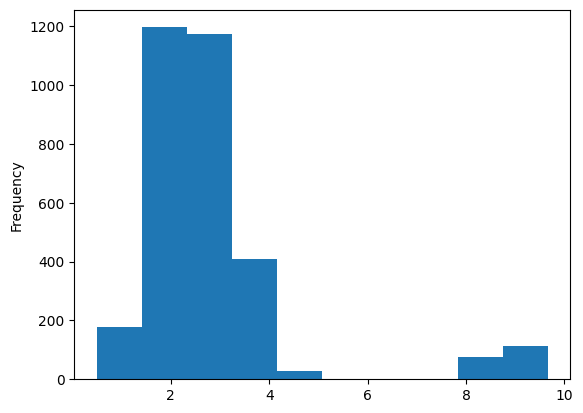

In [26]:
df.Total_UNCY.plot.hist()

In [27]:
df.groupby("filename").Total_UNCY.mean().sort_values(ascending=False).head(50)

filename
Retrolens/Nelson/BoulderBank/Shorelines/BoulderBank_06FEB1967.shp                 9.665489
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_04FEB1967.shp                 9.644290
Retrolens/Southland/MasonsBay/Shorelines/MasonsBay_10DEC1958.shp                  9.207819
Retrolens/Manawatu/Akitio/Shorelines/Akitio_27NOV1994.shp                         9.182351
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_31JAN1980.shp                 9.174151
Retrolens/Bay of Plenty/PapateaBay/Shorelines/PapateaBay_31MAR1960.shp            9.172843
Retrolens/HawkesBay/Nuhaka/Shorelines/Nuhaka_16JAN2003.shp                        9.137048
Retrolens/HawkesBay/MohakaRiver_East/Shorelines/MohakaRiver_East_16JAN2003.shp    9.136349
Retrolens/Manawatu/WaikawaBeach/Shorelines/WaikawaBeach_15JAN1957.shp             8.972346
Retrolens/Bay of Plenty/PapateaBay/Shorelines/PapateaBay_1OCT1980.shp             8.958592
Retrolens/HawkesBay/MohakaRiver_East/Shorelines/MohakaRiver_East_1DEC1970.shp    